# 🚀 Crypto Prediction Model Training - Padded Scaling Approach

This notebook trains an LSTM model using the **padded scaling approach** with OHLC-only data.

## Key Features:
- **OHLC-only data** (Volume removed)
- **Padded scaling** with configurable padding factor
- **Unified input/output scaling** using same min/max values
- **Target clamping** to prevent exceeding valid range
- **Combined input+output visualization** for continuous charting

## Approach:
1. Load and prepare OHLC data
2. Apply padded scaling (input scaled to [padding, 1-padding] range)
3. Scale targets using input min/max but clamp to [0, 1] range
4. Train LSTM model on scaled sequences
5. Evaluate and visualize results


In [1]:
# Cell 1: Imports and Setup
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure matplotlib for notebook environment
plt.style.use('default')

# Import our updated utilities
from src import (
    BinanceDataOrganizer,
    create_lstm_model, evaluate_model, predict_next_candle, add_open_to_predictions,
    draw_candlestick_chart, plot_combined_input_output_charts, plot_sample_data_comparison,
    plot_training_history, plot_predictions_vs_actual,
    production_config, test_config
)

print("✅ Imports successful - New approach ready!")


✅ Imports successful - New approach ready!


## 1. Configuration Selection

Choose between production and test configurations:

- **Production Config**: Full-scale deployment with larger models and more data
- **Test Config**: Fast execution for development and testing


In [2]:
# Cell 2: Configuration Selection
CONFIG_MODE = 'test'  # Change to 'production' for full-scale deployment

if CONFIG_MODE == 'production':
    config = production_config
    print("🚀 PRODUCTION mode")
else:
    config = test_config
    print("⚡ TEST mode")

print(f"Config: {config.symbol} {config.timeframe} | {config.start_date} to {config.end_date}")
print(f"Model: {config.lstm_units} units, {config.epochs} epochs, {config.sequence_length}→{config.prediction_length}")
print(f"Features: OHLC only (Volume removed)")
print(f"Scaling: Padded scaling (padding factor: {config.scaling_padding_factor})")


⚡ TEST mode
Config: BTCUSDT 5m | 2021-01 to 2021-01
Model: 20 units, 5 epochs, 50→20
Features: OHLC only (Volume removed)
Scaling: Padded scaling (padding factor: 0.5)


## 2. Data Loading and Scaling

Load cryptocurrency data and apply the new expanded range scaling approach.


In [3]:
# Cell 3: Data Loading and Scaling
print("📊 Loading data with padded scaling approach...")

# Create data organizer
organizer = BinanceDataOrganizer(config)

# Get unscaled data for analysis
unscaled_data = organizer.get_unscaled_split_data()
X_train_unscaled = unscaled_data['input_train']
y_train_unscaled = unscaled_data['output_train']
X_test_unscaled = unscaled_data['input_test']
y_test_unscaled = unscaled_data['output_test']

# Get scaled data using new padded scaling approach
scaled_data = organizer.get_scaled_data()
X_train_scaled = scaled_data['input_train_scaled']
y_train_scaled = scaled_data['output_train_scaled']
X_test_scaled = scaled_data['input_test_scaled']
y_test_scaled = scaled_data['output_test_scaled']

# Essential data summary
print(f"Data shapes: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}")
print(f"Input range: {X_train_scaled.min():.3f} to {X_train_scaled.max():.3f}")
print(f"Target range: {y_train_scaled.min():.3f} to {y_train_scaled.max():.3f}")
print(f"Padding factor: {config.scaling_padding_factor} (scales input to [{config.scaling_padding_factor/2:.2f}, {1-config.scaling_padding_factor/2:.2f}])")
print("✅ Data loaded and scaled successfully!")


📊 Loading data with padded scaling approach...
Data shapes: Train (6201, 50, 4), Test (2658, 50, 4)
Input range: 0.250 to 0.750
Target range: 0.000 to 1.000
Padding factor: 0.5 (scales input to [0.25, 0.75])
✅ Data loaded and scaled successfully!


## 3. Data Visualization

Visualize the unscaled and scaled data using candlestick charts.


📊 Creating data visualizations...
Visualizing first sequence: 70 timesteps (50 input + 20 output)

📊 TRAINING DATA VISUALIZATION

1️⃣ Unscaled Data Candlestick Chart (Input + Output):
   📊 Chart Y-axis: 28651.178500 to 29508.991500 (data range: 28690.170000 to 29470.000000)


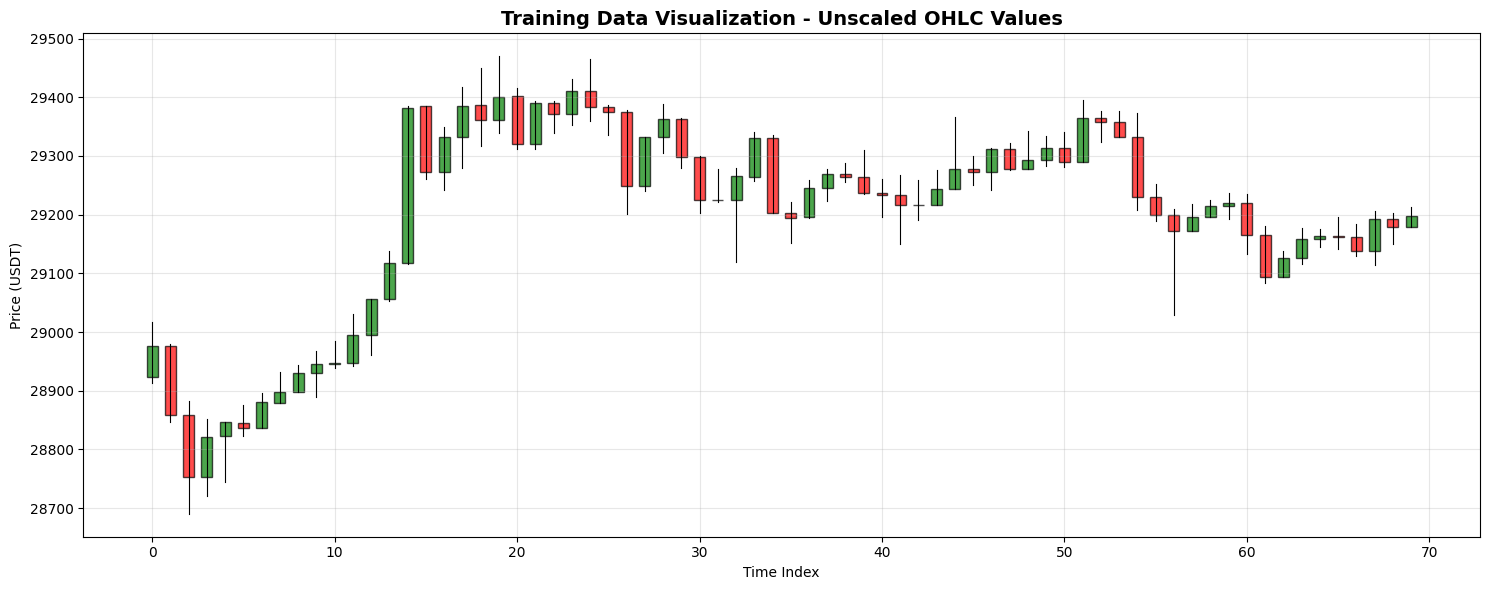


2️⃣ Scaled Data Candlestick Chart (Input + Output):
   📊 Chart Y-axis: 0.225000 to 0.775000 (data range: 0.250000 to 0.750000)


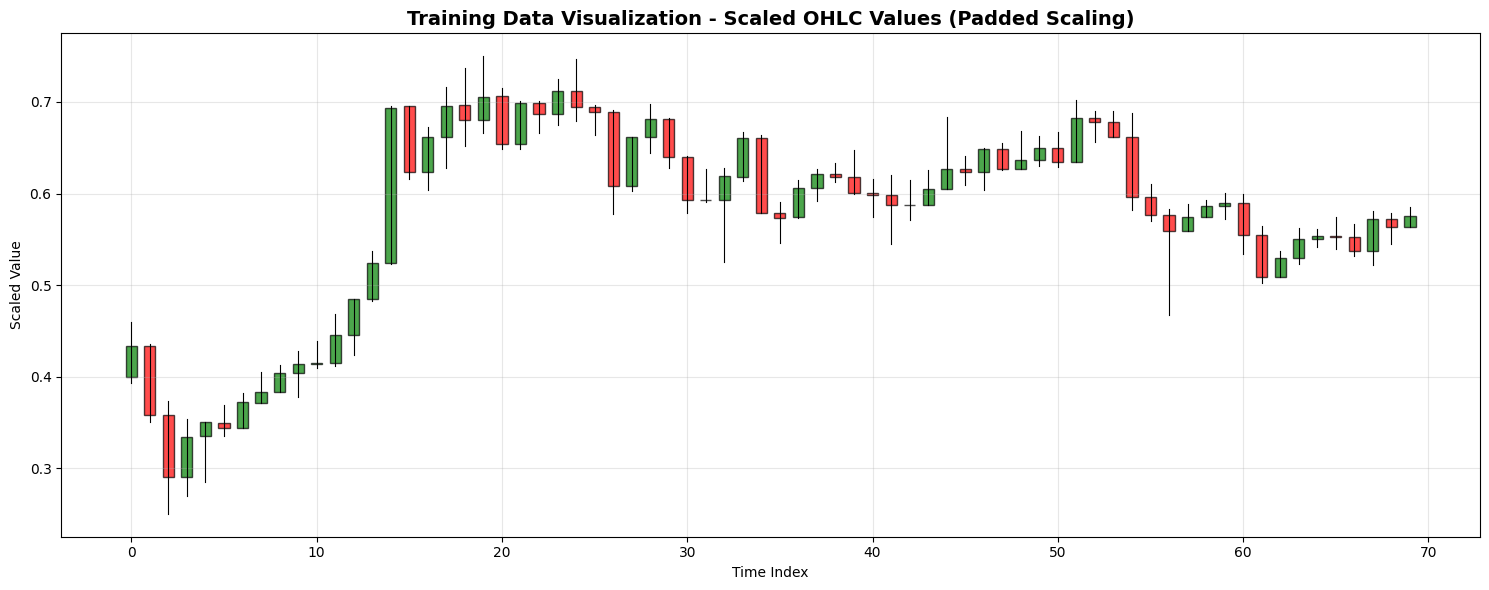


📊 CHART SUMMARY STATISTICS:
   Unscaled OHLC range: 28690.17 to 29470.00
   Scaled OHLC range: 0.250000 to 0.750000

📊 High-Low Relationship Check:
   Unscaled - All positive: True
   Scaled - All positive: True

📊 Input vs Output Analysis:
   Input timesteps (0-49):
     Unscaled range: 28690.17 to 29470.00
     Scaled range: 0.250000 to 0.750000
   Output timesteps (50-69):
     Unscaled range: 29029.40 to 29395.00
     Scaled range: 0.467503 to 0.701913

✅ All candlestick charts displayed successfully!
   Charts show combined Input + Output data for continuous visualization
   Output scaling uses expanded range approach for 0-1 consistency

📊 SAMPLE DATA COMPARISON - COMBINED INPUT + OUTPUT
🔍 UNSCALED DATA (first 10 rows - Input + Output):
Index    Open      High      Low       Close
---------------------------------------------
    0  28923.63  29017.50  28913.12  28975.65
    1  28975.65  28979.53  28846.28  28858.94
    2  28858.94  28883.20  28690.17  28752.80
    3  28752.80  

In [4]:
# Cell 4: Data Visualization
print("📊 Creating data visualizations...")

# Combine first sequence for visualization
first_sequence_unscaled = organizer.combine_input_output_for_chart(X_train_unscaled[0], y_train_unscaled[0])
first_sequence_scaled = organizer.combine_input_output_for_chart(X_train_scaled[0], y_train_scaled[0])

print(f"Visualizing first sequence: {len(first_sequence_unscaled)} timesteps ({config.sequence_length} input + {config.prediction_length} output)")

# Display combined charts
plot_combined_input_output_charts(
    first_sequence_unscaled, 
    first_sequence_scaled, 
    config, 
    'Training Data Visualization'
)

# Display sample data comparison
plot_sample_data_comparison(
    first_sequence_unscaled, 
    first_sequence_scaled, 
    config, 
    num_samples=10
)

print("✅ Data visualization completed!")


## 4. Model Creation and Training

Create and train the LSTM model using the new approach.


In [5]:
# Cell 5: Model Creation
print("🤖 Creating LSTM model...")

# Create model with updated architecture
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (sequence_length, features)
model = create_lstm_model(
    input_shape=input_shape,
    lstm_units=config.lstm_units,
    dropout_rate=config.dropout_rate,
    learning_rate=config.learning_rate,
    prediction_length=config.prediction_length
)

print(f"Model: {model.count_params():,} parameters, input {input_shape}, output {config.prediction_length * 3} (HLC)")
print("✅ Model created successfully!")


🤖 Creating LSTM model...
Model: 7,365 parameters, input (50, 4), output 60 (HLC)
✅ Model created successfully!


I0000 00:00:1757156963.890317 15508244 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1757156963.890348 15508244 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


🚀 Training LSTM model...
Config: 5 epochs, batch 1024, lr 0.001
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0418 - mae: 0.1641 - val_loss: 0.0417 - val_mae: 0.1661 - learning_rate: 0.0010
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0412 - mae: 0.1628 - val_loss: 0.0416 - val_mae: 0.1659 - learning_rate: 0.0010
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0406 - mae: 0.1613 - val_loss: 0.0415 - val_mae: 0.1656 - learning_rate: 0.0010
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0398 - mae: 0.1589 - val_loss: 0.0414 - val_mae: 0.1654 - learning_rate: 5.0000e-04
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0399 - mae: 0.1593 - val_loss: 0.0413 - val_mae: 0.1651 - learning_rate: 5.0000e-04
Training completed: Loss 0.0399, Val Loss 0.0413
MAE: 0.1591, Val MAE: 0.1651


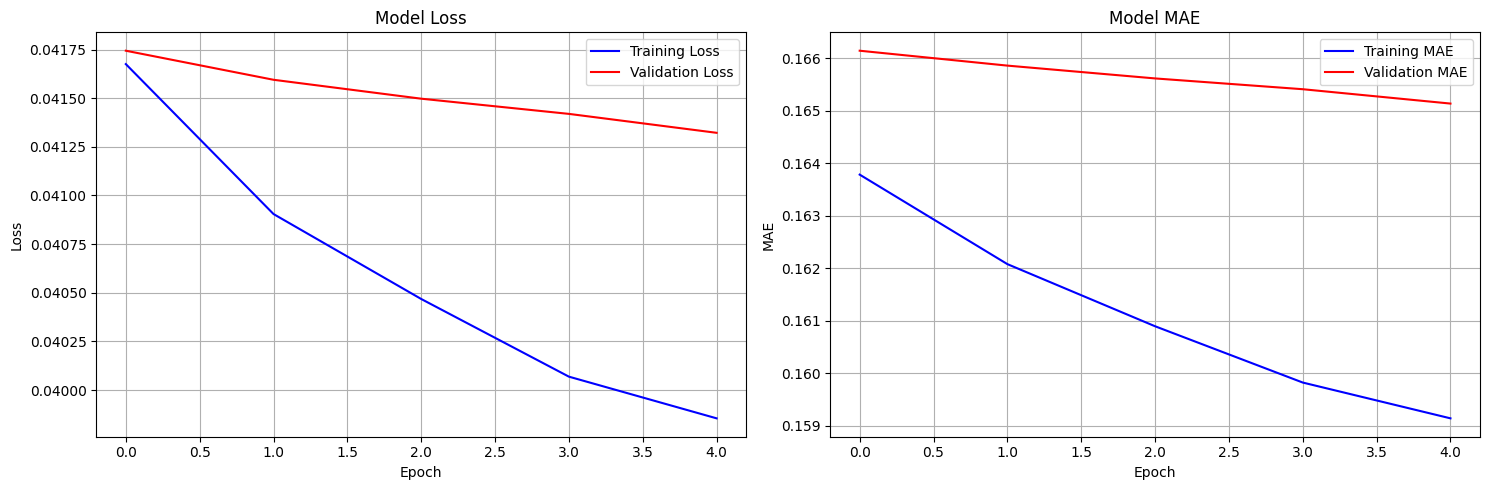

In [6]:
# Cell 6: Model Training
print("🚀 Training LSTM model...")
print(f"Config: {config.epochs} epochs, batch {config.batch_size}, lr {config.learning_rate}")

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=config.epochs,
    batch_size=config.batch_size,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=config.patience, 
            restore_best_weights=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=config.lr_patience, 
            factor=config.lr_factor, 
            min_lr=config.min_lr,
            monitor='val_loss'
        )
    ]
)

print(f"Training completed: Loss {history.history['loss'][-1]:.4f}, Val Loss {history.history['val_loss'][-1]:.4f}")
print(f"MAE: {history.history['mae'][-1]:.4f}, Val MAE: {history.history['val_mae'][-1]:.4f}")

# Display training history
plot_training_history(history)


## 5. Model Evaluation and Testing

Evaluate the trained model and test predictions.


📊 Evaluating trained model...
Test Results: MSE 0.0413, MAE 0.1651
MAPE: 35546632.98%, RMSE: 0.2033
Predictions: (2658, 60), range 0.471 to 0.580


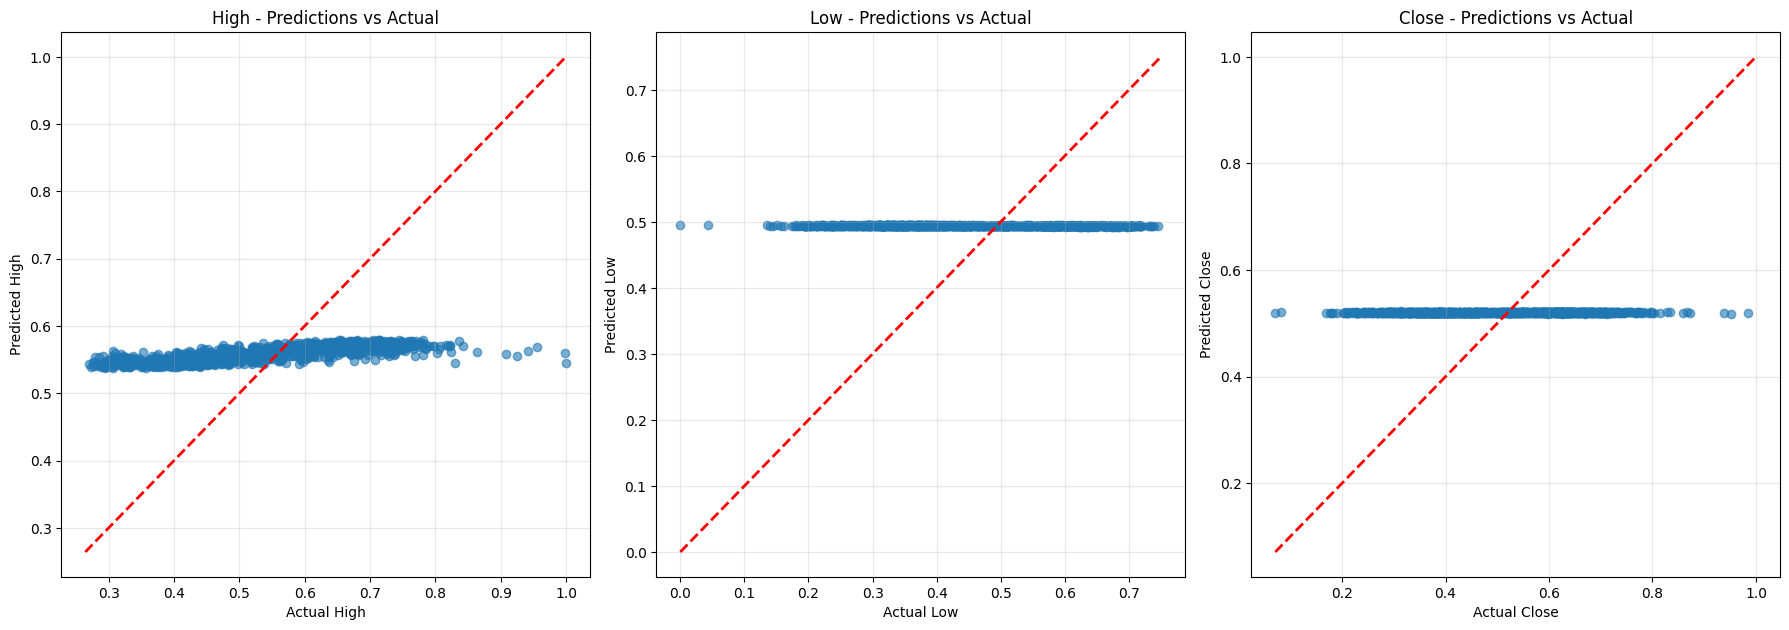

✅ Model evaluation completed!


In [7]:
# Cell 7: Model Evaluation
print("📊 Evaluating trained model...")

# Evaluate on test data
test_metrics = evaluate_model(model, X_test_scaled, y_test_scaled)

print(f"Test Results: MSE {test_metrics['test_loss']:.4f}, MAE {test_metrics['test_mae']:.4f}")
print(f"MAPE: {test_metrics['test_mape']:.2f}%, RMSE: {test_metrics['rmse']:.4f}")

# Get predictions for visualization
predictions_scaled = test_metrics['predictions']
output_true_scaled = test_metrics['output_true']

print(f"Predictions: {predictions_scaled.shape}, range {predictions_scaled.min():.3f} to {predictions_scaled.max():.3f}")

# Plot predictions vs actual
plot_predictions_vs_actual(
    predictions_scaled, 
    output_true_scaled, 
    ['High', 'Low', 'Close'], 
    max_samples=1000
)

print("✅ Model evaluation completed!")


## 6. Prediction Visualization

Visualize model predictions using candlestick charts.


📈 Visualizing model predictions...
   📊 Chart Y-axis: 0.225000 to 0.775000 (data range: 0.250000 to 0.750000)


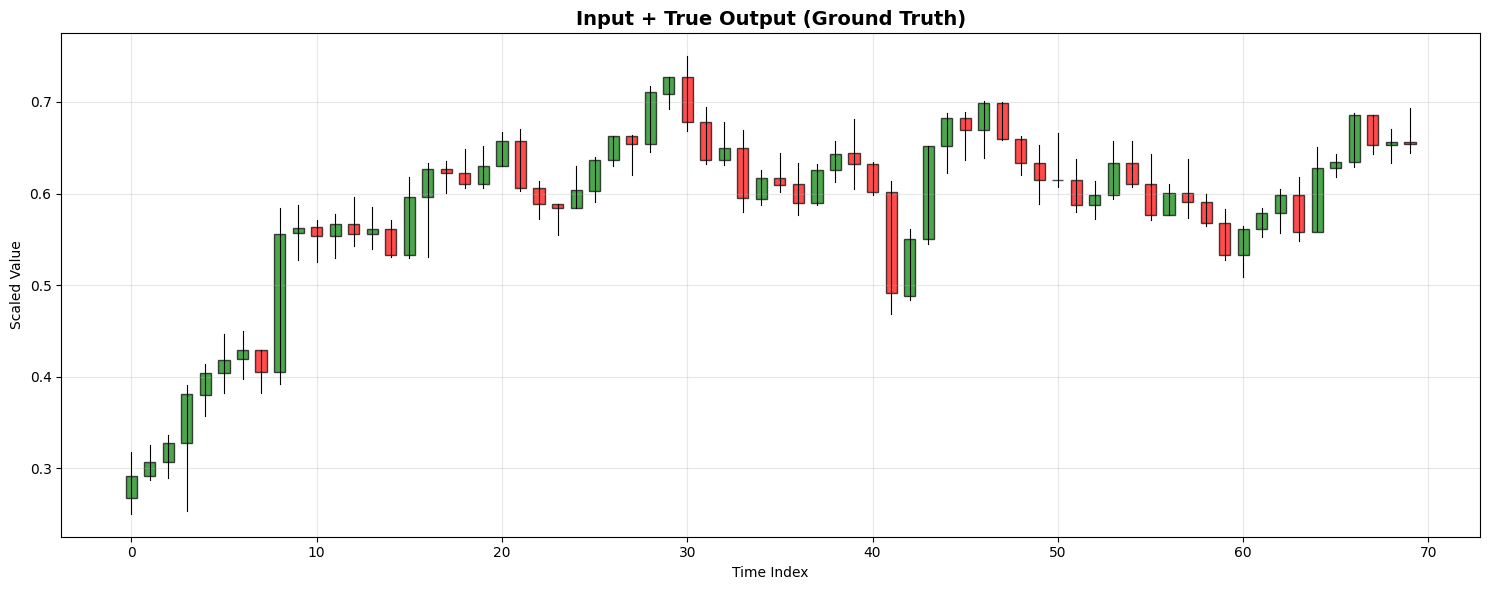

   📊 Chart Y-axis: 0.225000 to 0.775000 (data range: 0.250000 to 0.750000)


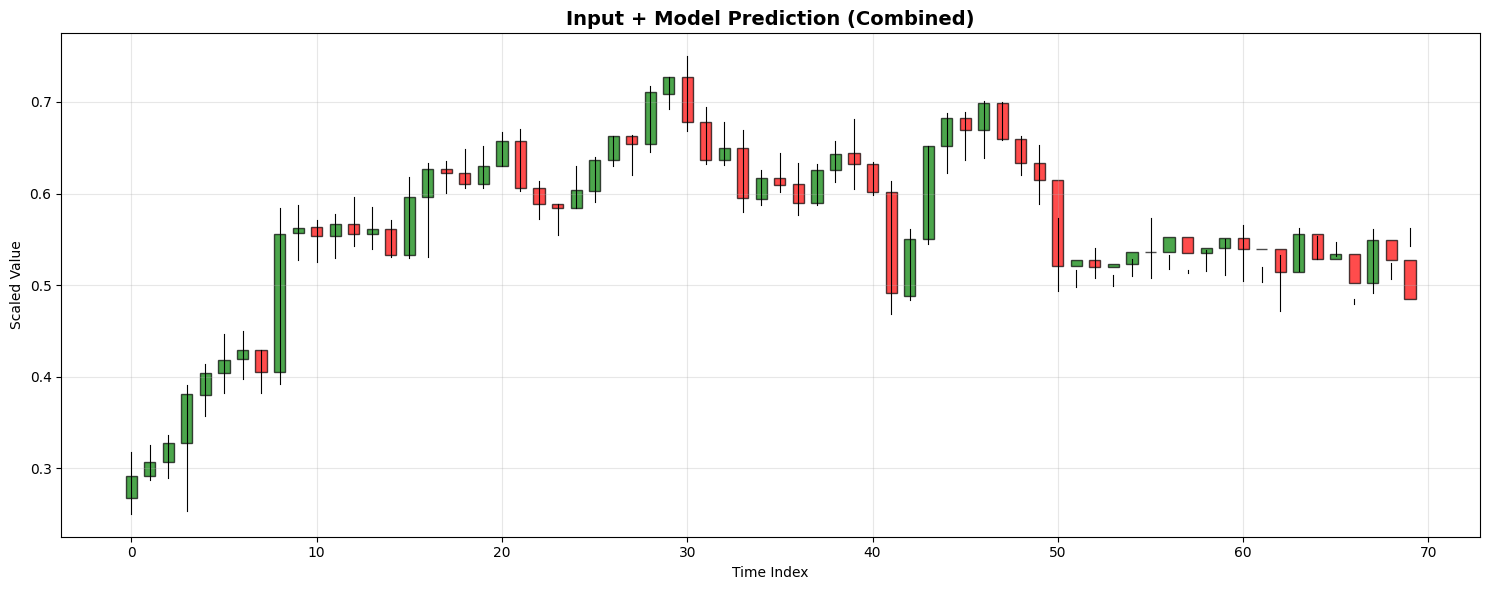

Prediction MAE: 0.0793
✅ Prediction visualization completed!


In [8]:
# Cell 8: Prediction Visualization
print("📈 Visualizing model predictions...")

# Select a test sequence for visualization
test_idx = 0
test_sequence = X_test_scaled[test_idx:test_idx+1]
test_output = y_test_scaled[test_idx]

# Make prediction
prediction_scaled = predict_next_candle(model, test_sequence)

# Add Open column to prediction for charting
last_close = test_sequence[0, -1, 3]  # Last Close from input
prediction_with_open = add_open_to_predictions(prediction_scaled, last_close)

# Reshape prediction to (prediction_length, 4) for charting
prediction_length = config.prediction_length
prediction_reshaped = prediction_with_open.reshape(prediction_length, 4)

# Combine input and prediction for continuous charting
input_sequence = test_sequence[0]  # Remove batch dimension
combined_prediction = np.vstack([input_sequence, prediction_reshaped])

# Chart 1: Input + True Output
true_output_with_open = organizer.add_open_to_output(input_sequence, test_output, config.prediction_length)
combined_true = np.vstack([input_sequence, true_output_with_open])
draw_candlestick_chart(
    combined_true, 
    'Input + True Output (Ground Truth)', 
    'Scaled Value'
)

# Chart 2: Input + Model Prediction
draw_candlestick_chart(
    combined_prediction, 
    'Input + Model Prediction (Combined)', 
    'Scaled Value'
)

# Calculate prediction accuracy
prediction_mae = np.mean(np.abs(prediction_reshaped - true_output_with_open))
print(f"Prediction MAE: {prediction_mae:.4f}")
print("✅ Prediction visualization completed!")


## 7. Model Performance Summary

Display comprehensive model performance metrics and analysis.


In [9]:
# Cell 9: Model Performance Summary
print("📊 Model Performance Summary")
print("=" * 40)

# Training performance
print(f"Training: Loss {history.history['loss'][-1]:.4f}, Val Loss {history.history['val_loss'][-1]:.4f}")
print(f"MAE: {history.history['mae'][-1]:.4f}, Val MAE: {history.history['val_mae'][-1]:.4f}")

# Test performance
print(f"Test: MSE {test_metrics['test_loss']:.4f}, MAE {test_metrics['test_mae']:.4f}")
print(f"MAPE: {test_metrics['test_mape']:.2f}%, RMSE: {test_metrics['rmse']:.4f}")

# Model architecture
print(f"Model: {model.count_params():,} params, {config.lstm_units} LSTM units")
print(f"Data: {X_train_scaled.shape[0]:,} train, {X_test_scaled.shape[0]:,} test samples")
print(f"Sequence: {config.sequence_length} → {config.prediction_length} timesteps")

# Scaling analysis
print(f"Scaling: Input [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}], Target [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")
print(f"Padding: {config.scaling_padding_factor} (input scaled to [{config.scaling_padding_factor/2:.2f}, {1-config.scaling_padding_factor/2:.2f}])")

print("✅ Model training completed successfully!")


📊 Model Performance Summary
Training: Loss 0.0399, Val Loss 0.0413
MAE: 0.1591, Val MAE: 0.1651
Test: MSE 0.0413, MAE 0.1651
MAPE: 35546632.98%, RMSE: 0.2033
Model: 7,365 params, 20 LSTM units
Data: 6,201 train, 2,658 test samples
Sequence: 50 → 20 timesteps
Scaling: Input [0.250, 0.750], Target [0.000, 1.000]
Padding: 0.5 (input scaled to [0.25, 0.75])
✅ Model training completed successfully!
